# A Walk Through Ensemble Models
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- get to know a useful package **pandas** for data analysis/preprocessing
- implement **decision tree** and apply it to a Titanic dataset
- implement a whole bunch of **ensemble methods**, including **random forest, and adaboost**, and apply them to a Titanic dataset

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [1]:
# some basic imports
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first do some data preprocessing

Here we use [pandas](https://pandas.pydata.org/) to do data preprocessing. Pandas is a very popular and handy package for data science or machine learning. You can also refer to this official guide for pandas: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

In [2]:
# read titanic train and test data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

print("train shape: {} test shape: {}".format(train.shape, test.shape))
# Showing overview of the train dataset
train.head(3)

train shape: (1047, 11) test shape: (262, 11)


,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C
1,3,0,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
2,3,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S


## deal with missing values and transform to discrete variables

In [3]:
# copied from: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,0,1,0,3,1,1,1,1,4
1,3,0,1,2,0,0,0,0,1,1,1
2,3,0,1,2,0,1,0,0,3,0,1
3,3,0,1,2,0,0,2,0,1,1,1
4,2,0,1,2,0,1,0,0,1,1,1


One of the good thing of pd.DataFrame is that you can keep the column names along with the data, which can be beneficial for many case.

Another good thing is that pd.DataFrame can be converted to np.array implicitely.

Also, pd provides a lot of useful data manipulating methods for your convenience, though we may not use them in this homework.

In [6]:
X = train.drop(['Survived'], axis=1)
y = train["Survived"]
X_test = test.drop(['Survived'], axis=1)
y_test = test["Survived"]
print("train: {}, test: {}".format(X.shape, X_test.shape))
print((np.array(X)).shape[1])

train: (1047, 10), test: (262, 10)
10


In [7]:
def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

In [8]:
print("Survived: {:.4f}, Not Survivied: {:.4f}".format(y.sum() / len(y), 1 - y.sum() / len(y)))

Survived: 0.3878, Not Survivied: 0.6122


## Decision Tree
Now it's your turn to do some real coding. Please implement the decision tree model in **decision_tree.py**. The PDF file provides some hints for this part.

{'Title': {1: {'Has_Cabin': {0: {'Pclass': {1: 0, 2: 0, 3: 0}}, 1: {'Fare': {0: 0, 1: 0, 2: 0, 3: 0}}}}, 2: {'FamilySize': {1: 0, 2: 1, 3: {'Pclass': {1: 1, 2: 1, 3: 1}}, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 11: 0}}, 3: {'Pclass': {1: {'FamilySize': {1: 1, 2: 1, 3: 1, 4: 1}}, 2: {'Parch': {0: 1, 1: 1, 2: 1, 3: 1}}, 3: {'FamilySize': {1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 11: 0}}}}, 4: {'Pclass': {1: {'FamilySize': {1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1}}, 2: {'Fare': {1: 1, 2: 1, 3: 1}}, 3: {'FamilySize': {1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 11: 0}}}}, 5: {'Has_Cabin': {0: {'FamilySize': {1: 0, 2: 0, 3: 0}}, 1: {'Age': {1: 1, 2: 0, 3: 1, 4: 0}}}}}}
Accuracy on train set: 0.8223495702005731


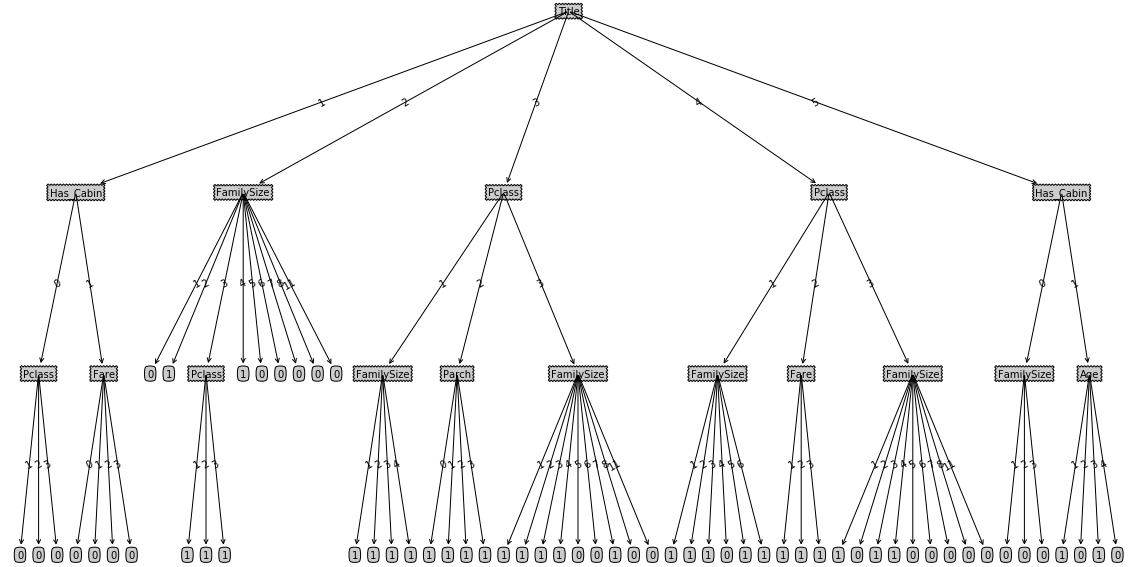

In [9]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='gini', max_depth=4, min_samples_leaf=4, sample_feature=False)
dt.fit(X, y)
print(dt._tree)
y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [17]:
# TODO: Train the best DecisionTree(best val accuracy) that you can. You should choose some 
# hyper-parameters such as critertion, max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# To reduce difficulty, you can use KFold here.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters=['entropy', 'infogain_ratio','gini']
depths=[3, 4, 5, 6, 7, 8]
leaves=[1, 4, 8, 16, 32, 64]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_score=0.0

for depth in depths:
    for leaf in leaves:
        for criter in criters:
            print('{} {} {}'.format(depth, leaf, criter))
            dt = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
            pred=np.zeros(len(X))
            for train_indice, valid_indice in kf.split(X, y):
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
               # print(X_train_fold.shape, X_val_fold.shape)
                dt.fit(X_train_fold, y_train_fold)
                pred[valid_indice]=dt.predict(X_val_fold)
            score=accuracy(y, pred)
            if score>best_score:
                best_score=score
                best_criter=criter
                best_depth=depth
                best_leaf=leaf
            print("Accuracy on validation set: {}".format(score))            
# begin answer
print('{} {} {}'.format(best_criter, best_depth, best_leaf))
dt=DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=False)
# end answer
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))
# end answer

3 1 entropy
Accuracy on validation set: 0.7908309455587392
3 1 infogain_ratio
Accuracy on validation set: 0.7774594078319007
3 1 gini
Accuracy on validation set: 0.792741165234002
3 4 entropy
Accuracy on validation set: 0.7889207258834766
3 4 infogain_ratio
Accuracy on validation set: 0.7774594078319007
3 4 gini
Accuracy on validation set: 0.792741165234002
3 8 entropy
Accuracy on validation set: 0.789875835721108
3 8 infogain_ratio
Accuracy on validation set: 0.7774594078319007
3 8 gini
Accuracy on validation set: 0.7917860553963706
3 16 entropy
Accuracy on validation set: 0.7870105062082139
3 16 infogain_ratio
Accuracy on validation set: 0.7774594078319007
3 16 gini
Accuracy on validation set: 0.7870105062082139
3 32 entropy
Accuracy on validation set: 0.7841451766953199
3 32 infogain_ratio
Accuracy on validation set: 0.7774594078319007
3 32 gini
Accuracy on validation set: 0.7831900668576887
3 64 entropy
Accuracy on validation set: 0.7640878701050621
3 64 infogain_ratio
Accuracy on 

In [14]:
# report the accuracy on test set
# begin answer
criters=['entropy', 'infogain_ratio','gini']
depths=[3, 4, 5, 6, 7, 8]
leaves=[1, 4, 8, 16, 32, 64]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_score=0.0
for depth in depths:
    for leaf in leaves:
        for criter in criters:
            print('{} {} {}'.format(depth, leaf, criter))
            dt=DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
            dt.fit(X, y)
            score=accuracy(y_test, dt.predict(X_test))
            if score > best_score:
                best_score=score
                best_criter=criter
                best_depth=depth
                best_leaf=leaf
            print("Accuracy on test set: {}".format(score))
                
            
print('{} {} {}'.format(best_criter, best_depth, best_leaf))
dt=DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=False)
# end answer
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

3 1 entropy
Accuracy on test set: 0.8129770992366412
3 1 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 1 gini
Accuracy on test set: 0.8129770992366412
3 4 entropy
Accuracy on test set: 0.8129770992366412
3 4 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 4 gini
Accuracy on test set: 0.8129770992366412
3 8 entropy
Accuracy on test set: 0.8129770992366412
3 8 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 8 gini
Accuracy on test set: 0.8129770992366412
3 16 entropy
Accuracy on test set: 0.8129770992366412
3 16 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 16 gini
Accuracy on test set: 0.8129770992366412
3 32 entropy
Accuracy on test set: 0.8129770992366412
3 32 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 32 gini
Accuracy on test set: 0.8129770992366412
3 64 entropy
Accuracy on test set: 0.7900763358778626
3 64 infogain_ratio
Accuracy on test set: 0.7709923664122137
3 64 gini
Accuracy on test set: 0.7900763358778626
4 1 entropy
A

## Random Forest
Please implement the random forest model in **random_forest.py**. The PDF file provides some hints for this part.

In [18]:
from random_forest import RandomForest

base_learner = DecisionTree(criterion='infogain_ratio', max_depth=6, min_samples_leaf=6, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=100, seed=2020)
rf.fit(X, y)

y_train_pred = rf.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.830945558739255
Accuracy on test set: 0.8129770992366412


In [16]:
# TODO: Train the best RandomForest that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters=['entropy', 'infogain_ratio','gini']
depths=[3, 4, 5, 6, 7, 8]
leaves=[1, 4, 8, 16, 32, 64]
estimators=[10, 20, 40, 100]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_estimator=estimators[0]
best_score=0.0

for depth in depths:
    for leaf in leaves:
        for criter in criters:
            for estimator in estimators:
                print('{} {} {} {}'.format(depth, leaf, criter, estimator))
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=True)
                rf = RandomForest(base_learner=base_learner, n_estimator=estimator, seed=2020)
                pred=np.zeros(len(X))
                for train_indice, valid_indice in kf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                   # print(X_train_fold.shape, X_val_fold.shape)
                    rf.fit(X_train_fold, y_train_fold)
                    pred[valid_indice]=rf.predict(X_val_fold)
                score=accuracy(y, pred)
                if score>best_score:
                    best_score=score
                    best_criter=criter
                    best_depth=depth
                    best_leaf=leaf
                    best_estimator=estimator
                print("Accuracy on validation set: {}".format(score))
print('{} {} {} {}'.format(best_criter, best_depth, best_leaf, best_estimator))
base_learner = DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=best_estimator, seed=2020)
# end answer
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))
# end answer

3 1 entropy 10
Accuracy on validation set: 0.7640878701050621
3 1 entropy 20
Accuracy on validation set: 0.7526265520534862
3 1 entropy 40
Accuracy on validation set: 0.7812798471824259
3 1 entropy 100
Accuracy on validation set: 0.775549188156638
3 1 infogain_ratio 10
Accuracy on validation set: 0.772683858643744
3 1 infogain_ratio 20
Accuracy on validation set: 0.7717287488061128
3 1 infogain_ratio 40
Accuracy on validation set: 0.7688634192932188
3 1 infogain_ratio 100
Accuracy on validation set: 0.775549188156638
3 1 gini 10
Accuracy on validation set: 0.7593123209169055
3 1 gini 20
Accuracy on validation set: 0.7535816618911175
3 1 gini 40
Accuracy on validation set: 0.7707736389684814
3 1 gini 100
Accuracy on validation set: 0.7851002865329513
3 4 entropy 10
Accuracy on validation set: 0.7640878701050621
3 4 entropy 20
Accuracy on validation set: 0.7507163323782235
3 4 entropy 40
Accuracy on validation set: 0.7803247373447947
3 4 entropy 100
Accuracy on validation set: 0.77077363

Accuracy on validation set: 0.7736389684813754
4 32 gini 20
Accuracy on validation set: 0.7860553963705826
4 32 gini 40
Accuracy on validation set: 0.7879656160458453
4 32 gini 100
Accuracy on validation set: 0.7879656160458453
4 64 entropy 10
Accuracy on validation set: 0.778414517669532
4 64 entropy 20
Accuracy on validation set: 0.778414517669532
4 64 entropy 40
Accuracy on validation set: 0.7812798471824259
4 64 entropy 100
Accuracy on validation set: 0.7812798471824259
4 64 infogain_ratio 10
Accuracy on validation set: 0.7812798471824259
4 64 infogain_ratio 20
Accuracy on validation set: 0.7936962750716332
4 64 infogain_ratio 40
Accuracy on validation set: 0.792741165234002
4 64 infogain_ratio 100
Accuracy on validation set: 0.7889207258834766
4 64 gini 10
Accuracy on validation set: 0.76981852913085
4 64 gini 20
Accuracy on validation set: 0.7812798471824259
4 64 gini 40
Accuracy on validation set: 0.7889207258834766
4 64 gini 100
Accuracy on validation set: 0.7889207258834766
5 

Accuracy on validation set: 0.7984718242597899
6 16 infogain_ratio 40
Accuracy on validation set: 0.7956064947468959
6 16 infogain_ratio 100
Accuracy on validation set: 0.7917860553963706
6 16 gini 10
Accuracy on validation set: 0.8032473734479465
6 16 gini 20
Accuracy on validation set: 0.7908309455587392
6 16 gini 40
Accuracy on validation set: 0.7975167144221585
6 16 gini 100
Accuracy on validation set: 0.8013371537726839
6 32 entropy 10
Accuracy on validation set: 0.7841451766953199
6 32 entropy 20
Accuracy on validation set: 0.7841451766953199
6 32 entropy 40
Accuracy on validation set: 0.7889207258834766
6 32 entropy 100
Accuracy on validation set: 0.7965616045845272
6 32 infogain_ratio 10
Accuracy on validation set: 0.7765042979942693
6 32 infogain_ratio 20
Accuracy on validation set: 0.7793696275071633
6 32 infogain_ratio 40
Accuracy on validation set: 0.7870105062082139
6 32 infogain_ratio 100
Accuracy on validation set: 0.7870105062082139
6 32 gini 10
Accuracy on validation s

Accuracy on validation set: 0.7841451766953199
8 8 entropy 100
Accuracy on validation set: 0.7908309455587392
8 8 infogain_ratio 10
Accuracy on validation set: 0.7851002865329513
8 8 infogain_ratio 20
Accuracy on validation set: 0.792741165234002
8 8 infogain_ratio 40
Accuracy on validation set: 0.792741165234002
8 8 infogain_ratio 100
Accuracy on validation set: 0.7879656160458453
8 8 gini 10
Accuracy on validation set: 0.7822349570200573
8 8 gini 20
Accuracy on validation set: 0.7965616045845272
8 8 gini 40
Accuracy on validation set: 0.7841451766953199
8 8 gini 100
Accuracy on validation set: 0.7889207258834766
8 16 entropy 10
Accuracy on validation set: 0.7841451766953199
8 16 entropy 20
Accuracy on validation set: 0.792741165234002
8 16 entropy 40
Accuracy on validation set: 0.7965616045845272
8 16 entropy 100
Accuracy on validation set: 0.7936962750716332
8 16 infogain_ratio 10
Accuracy on validation set: 0.7879656160458453
8 16 infogain_ratio 20
Accuracy on validation set: 0.790

In [13]:
# report the accuracy on test set
# begin answer
criters=['entropy', 'infogain_ratio','gini']
depths=[3, 4, 5, 6, 7, 8]
leaves=[1, 4, 8, 16, 32, 64]
estimators=[10, 20, 40, 100]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_estimator=estimators[0]
best_score=0.0

for depth in depths:
    for leaf in leaves:
        for criter in criters:
            for estimator in estimators:
                print('{} {} {} {}'.format(depth, leaf, criter, estimator))
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=True)
                rf = RandomForest(base_learner=base_learner, n_estimator=estimator, seed=2020)
                rf.fit(X, y)
                score=accuracy(y_test, rf.predict(X_test))
                if score>best_score:
                    best_score=score
                    best_criter=criter
                    best_depth=depth
                    best_leaf=leaf
                    best_estimator=estimator
                print("Accuracy on test set: {}".format(score))

print('{} {} {} {}'.format(best_criter, best_depth, best_leaf, best_estimator))
base_learner = DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=best_estimator, seed=2020)
# end answer
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

3 1 entropy 10
Accuracy on test set: 0.7557251908396947
3 1 entropy 20
Accuracy on test set: 0.7786259541984732
3 1 entropy 40
Accuracy on test set: 0.7595419847328244
3 1 entropy 100
Accuracy on test set: 0.8053435114503816
3 1 infogain_ratio 10
Accuracy on test set: 0.7748091603053435
3 1 infogain_ratio 20
Accuracy on test set: 0.7748091603053435
3 1 infogain_ratio 40
Accuracy on test set: 0.7862595419847328
3 1 infogain_ratio 100
Accuracy on test set: 0.7862595419847328
3 1 gini 10
Accuracy on test set: 0.7709923664122137
3 1 gini 20
Accuracy on test set: 0.767175572519084
3 1 gini 40
Accuracy on test set: 0.7977099236641222
3 1 gini 100
Accuracy on test set: 0.7862595419847328
3 4 entropy 10
Accuracy on test set: 0.7557251908396947
3 4 entropy 20
Accuracy on test set: 0.7786259541984732
3 4 entropy 40
Accuracy on test set: 0.7595419847328244
3 4 entropy 100
Accuracy on test set: 0.8053435114503816
3 4 infogain_ratio 10
Accuracy on test set: 0.7748091603053435
3 4 infogain_ratio 20


Accuracy on test set: 0.8015267175572519
4 64 gini 40
Accuracy on test set: 0.8129770992366412
4 64 gini 100
Accuracy on test set: 0.8015267175572519
5 1 entropy 10
Accuracy on test set: 0.7748091603053435
5 1 entropy 20
Accuracy on test set: 0.7900763358778626
5 1 entropy 40
Accuracy on test set: 0.816793893129771
5 1 entropy 100
Accuracy on test set: 0.8091603053435115
5 1 infogain_ratio 10
Accuracy on test set: 0.7900763358778626
5 1 infogain_ratio 20
Accuracy on test set: 0.8053435114503816
5 1 infogain_ratio 40
Accuracy on test set: 0.8091603053435115
5 1 infogain_ratio 100
Accuracy on test set: 0.816793893129771
5 1 gini 10
Accuracy on test set: 0.8091603053435115
5 1 gini 20
Accuracy on test set: 0.8244274809160306
5 1 gini 40
Accuracy on test set: 0.8244274809160306
5 1 gini 100
Accuracy on test set: 0.8206106870229007
5 4 entropy 10
Accuracy on test set: 0.8129770992366412
5 4 entropy 20
Accuracy on test set: 0.8053435114503816
5 4 entropy 40
Accuracy on test set: 0.8053435114

Accuracy on test set: 0.8129770992366412
6 64 gini 10
Accuracy on test set: 0.8015267175572519
6 64 gini 20
Accuracy on test set: 0.8091603053435115
6 64 gini 40
Accuracy on test set: 0.7977099236641222
6 64 gini 100
Accuracy on test set: 0.8053435114503816
7 1 entropy 10
Accuracy on test set: 0.8091603053435115
7 1 entropy 20
Accuracy on test set: 0.8091603053435115
7 1 entropy 40
Accuracy on test set: 0.8206106870229007
7 1 entropy 100
Accuracy on test set: 0.816793893129771
7 1 infogain_ratio 10
Accuracy on test set: 0.8053435114503816
7 1 infogain_ratio 20
Accuracy on test set: 0.8053435114503816
7 1 infogain_ratio 40
Accuracy on test set: 0.8129770992366412
7 1 infogain_ratio 100
Accuracy on test set: 0.8129770992366412
7 1 gini 10
Accuracy on test set: 0.8129770992366412
7 1 gini 20
Accuracy on test set: 0.816793893129771
7 1 gini 40
Accuracy on test set: 0.8206106870229007
7 1 gini 100
Accuracy on test set: 0.8206106870229007
7 4 entropy 10
Accuracy on test set: 0.82442748091603

Accuracy on test set: 0.8053435114503816
8 64 infogain_ratio 40
Accuracy on test set: 0.8053435114503816
8 64 infogain_ratio 100
Accuracy on test set: 0.816793893129771
8 64 gini 10
Accuracy on test set: 0.7938931297709924
8 64 gini 20
Accuracy on test set: 0.7938931297709924
8 64 gini 40
Accuracy on test set: 0.8091603053435115
8 64 gini 100
Accuracy on test set: 0.8206106870229007
entropy 8 4 10
Accuracy on train set: 0.8510028653295129
Accuracy on test set: 0.8358778625954199


## Adaboost
Please implement the adaboost model in **adaboost.py**. The PDF file provides some hints for this part.

In [18]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=50, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.7793696275071633


In [19]:
# TODO: Train the best Adaboost that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters=['entropy', 'infogain_ratio','gini']
depths=[2, 3, 4, 5]
leaves=[1, 4, 8, 16, 32, 64]
estimators=[10, 20, 50, 100]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_estimator=estimators[0]
best_score=0.0
for depth in depths:
    for leaf in leaves:
        for criter in criters:
            for estimator in estimators:
                print('{} {} {} {}'.format(depth, leaf, criter, estimator))
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
                ada = Adaboost(base_learner=base_learner, n_estimator=estimator, seed=2020)
                pred=np.zeros(len(X))
                for train_indice, valid_indice in kf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    # print(X_train_fold.shape, X_val_fold.shape)
                    ada.fit(X_train_fold, y_train_fold)
                    pred[valid_indice]=ada.predict(X_val_fold)
                score=accuracy(y, pred)
                if score>best_score:
                    best_score=score
                    best_criter=criter
                    best_depth=depth
                    best_leaf=leaf
                    best_estimator=estimator
                print("Accuracy on validation set: {}".format(score))
print('{} {} {} {}'.format(best_criter, best_depth, best_leaf, best_estimator))
base_learner = DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=best_estimator, seed=2020)
# end answer
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))
# end answer

2 1 entropy 10
Accuracy on validation set: 0.7583572110792741
2 1 entropy 20
Accuracy on validation set: 0.7583572110792741
2 1 entropy 50
Accuracy on validation set: 0.7583572110792741
2 1 entropy 100
Accuracy on validation set: 0.7583572110792741
2 1 infogain_ratio 10
Accuracy on validation set: 0.7621776504297995
2 1 infogain_ratio 20
Accuracy on validation set: 0.7621776504297995
2 1 infogain_ratio 50
Accuracy on validation set: 0.7621776504297995
2 1 infogain_ratio 100
Accuracy on validation set: 0.7621776504297995
2 1 gini 10
Accuracy on validation set: 0.7583572110792741
2 1 gini 20
Accuracy on validation set: 0.7583572110792741
2 1 gini 50
Accuracy on validation set: 0.7583572110792741
2 1 gini 100
Accuracy on validation set: 0.7583572110792741
2 4 entropy 10
Accuracy on validation set: 0.7583572110792741
2 4 entropy 20
Accuracy on validation set: 0.7583572110792741
2 4 entropy 50
Accuracy on validation set: 0.7583572110792741
2 4 entropy 100
Accuracy on validation set: 0.75835

Accuracy on validation set: 0.7936962750716332
3 32 gini 20
Accuracy on validation set: 0.7936962750716332
3 32 gini 50
Accuracy on validation set: 0.7936962750716332
3 32 gini 100
Accuracy on validation set: 0.7936962750716332
3 64 entropy 10
Accuracy on validation set: 0.772683858643744
3 64 entropy 20
Accuracy on validation set: 0.772683858643744
3 64 entropy 50
Accuracy on validation set: 0.772683858643744
3 64 entropy 100
Accuracy on validation set: 0.772683858643744
3 64 infogain_ratio 10
Accuracy on validation set: 0.7917860553963706
3 64 infogain_ratio 20
Accuracy on validation set: 0.7917860553963706
3 64 infogain_ratio 50
Accuracy on validation set: 0.7917860553963706
3 64 infogain_ratio 100
Accuracy on validation set: 0.7917860553963706
3 64 gini 10
Accuracy on validation set: 0.7745940783190067
3 64 gini 20
Accuracy on validation set: 0.7745940783190067
3 64 gini 50
Accuracy on validation set: 0.7745940783190067
3 64 gini 100
Accuracy on validation set: 0.7745940783190067
4

Accuracy on validation set: 0.7946513849092646
5 16 infogain_ratio 50
Accuracy on validation set: 0.792741165234002
5 16 infogain_ratio 100
Accuracy on validation set: 0.792741165234002
5 16 gini 10
Accuracy on validation set: 0.7736389684813754
5 16 gini 20
Accuracy on validation set: 0.7736389684813754
5 16 gini 50
Accuracy on validation set: 0.775549188156638
5 16 gini 100
Accuracy on validation set: 0.7745940783190067
5 32 entropy 10
Accuracy on validation set: 0.7688634192932188
5 32 entropy 20
Accuracy on validation set: 0.7688634192932188
5 32 entropy 50
Accuracy on validation set: 0.7688634192932188
5 32 entropy 100
Accuracy on validation set: 0.7688634192932188
5 32 infogain_ratio 10
Accuracy on validation set: 0.8022922636103151
5 32 infogain_ratio 20
Accuracy on validation set: 0.8022922636103151
5 32 infogain_ratio 50
Accuracy on validation set: 0.8022922636103151
5 32 infogain_ratio 100
Accuracy on validation set: 0.7994269340974212
5 32 gini 10
Accuracy on validation set:

In [12]:
# report the accuracy on test set
# begin answer
criters=['entropy', 'infogain_ratio','gini']
depths=[2, 3, 4, 5]
leaves=[1, 4, 8, 16, 32, 64]
estimators=[10, 20, 50, 100]
best_criter=criters[0]
best_depth=depths[0]
best_leaf=leaves[0]
best_estimator=estimators[0]
best_score=0.0
for depth in depths:
    for leaf in leaves:
        for criter in criters:
            for estimator in estimators:
                print('{} {} {} {}'.format(depth, leaf, criter, estimator))
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
                ada = Adaboost(base_learner=base_learner, n_estimator=estimator, seed=2020)
                ada.fit(X, y)
                score=accuracy(y_test, ada.predict(X_test))
                if score>best_score:
                    best_score=score
                    best_criter=criter
                    best_depth=depth
                    best_leaf=leaf
                    best_estimator=estimator
                print("Accuracy on test set: {}".format(score))
print('{} {} {} {}'.format(best_criter, best_depth, best_leaf, best_estimator))
base_learner = DecisionTree(criterion=best_criter, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=best_estimator, seed=2020)
# end answer
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))

infogain_ratio 4 32 10
Accuracy on train set: 0.8118433619866284
Accuracy on test set: 0.7938931297709924


## Gradient Boosting Decision Tree
First I implement a Decsion tree of regression(**regression_tree.py**) to handle discrete values, then I use this regression tree and logitloss for binary classification to predict the probabilty (assume >=0.5 is survived, the implementation of GBDT is in **GBDT.py**)


In [17]:
from GBDT import GBDT
from regression_tree import RegressionTree

base_learner = RegressionTree(max_depth=4, min_samples_leaf=4, sample_feature=False)
gbdt = GBDT(base_learner=base_learner, learning_rate=0.12, n_estimator=120)
gbdt.fit(X, y)

y_train_pred = gbdt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.839541547277937


In [20]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
depths=[3, 4, 5, 6]
estimators=[10, 20, 50, 100, 200]
learning_rates=[0.1,0.2,0.5]
best_depth=depths[0]
best_estimator=estimators[0]
best_lr=learning_rates[0]
best_score=0.0
for depth in depths:
    for estimator in estimators:
        for lr in learning_rates:
            print('{} {} {}'.format(depth, estimator, lr))
            base_learner = RegressionTree(max_depth=depth, min_samples_leaf=pow(2, depth-1), sample_feature=False)
            gbdt = GBDT(base_learner=base_learner, learning_rate=lr, n_estimator=estimator)
            pred=np.zeros(len(X))
            for train_indice, valid_indice in kf.split(X, y):
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                # print(X_train_fold.shape, X_val_fold.shape)
                gbdt.fit(X_train_fold, y_train_fold)
                pred[valid_indice]=gbdt.predict(X_val_fold)
            score=accuracy(y, pred)
            if score>best_score:
                best_score=score
                best_lr=lr
                best_depth=depth
                best_estimator=estimator
            print("Accuracy on validation set: {}".format(score))
print('{} {} {}'.format(best_depth, best_estimator, best_lr))
base_learner = RegressionTree(max_depth=best_depth, min_samples_leaf=pow(2, best_depth-1), sample_feature=False)
gbdt = GBDT(base_learner=base_learner, learning_rate=best_lr, n_estimator=best_estimator)
# end answer
gbdt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, gbdt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, gbdt.predict(X_test))))


3 10 0.1
Accuracy on validation set: 0.8051575931232091
3 10 0.2
Accuracy on validation set: 0.8032473734479465
3 10 0.5
Accuracy on validation set: 0.8051575931232091
3 20 0.1
Accuracy on validation set: 0.8042024832855779
3 20 0.2
Accuracy on validation set: 0.8051575931232091
3 20 0.5
Accuracy on validation set: 0.8032473734479465
3 50 0.1
Accuracy on validation set: 0.8099331423113658
3 50 0.2
Accuracy on validation set: 0.8061127029608405
3 50 0.5
Accuracy on validation set: 0.8070678127984718
3 100 0.1
Accuracy on validation set: 0.8070678127984718
3 100 0.2
Accuracy on validation set: 0.8099331423113658
3 100 0.5
Accuracy on validation set: 0.8080229226361032
3 200 0.1
Accuracy on validation set: 0.8108882521489972
3 200 0.2
Accuracy on validation set: 0.8080229226361032
3 200 0.5
Accuracy on validation set: 0.8032473734479465
4 10 0.1
Accuracy on validation set: 0.8003820439350525
4 10 0.2
Accuracy on validation set: 0.8089780324737345
4 10 0.5
Accuracy on validation set: 0.801

In [20]:
#simple comparsion of different models
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models=[GaussianNB(),
        Perceptron(),
        LogisticRegression(C=0.06),
        SVC(C=4,gamma=0.015),
        MLPClassifier(alpha=1),
        KNeighborsClassifier(n_neighbors=8),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=500),
        AdaBoostClassifier(n_estimators=500), 
        GradientBoostingClassifier(n_estimators=120,learning_rate=0.12,max_depth=4)]
names=['NB','Perception','LR','SVM','NN','KNN','DS','RF','Ada','GBDT']
for name,model in zip(names,models):
    score=cross_val_score(model,X,y,cv=5)
    print("{}: {},{}".format(name,score.mean(),score))

NB: 0.7611555817592235,[0.79620853 0.78947368 0.72727273 0.74641148 0.74641148]
Perception: 0.6945236853443388,[0.61137441 0.70334928 0.73205742 0.67942584 0.74641148]
LR: 0.771700038549627,[0.78672986 0.78947368 0.77033493 0.76076555 0.75119617]
SVM: 0.7937005374271526,[0.79146919 0.81339713 0.76555024 0.79904306 0.79904306]


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." %

NN: 0.7831651511372141,[0.79620853 0.79425837 0.77511962 0.77033493 0.77990431]
KNN: 0.7831832921381437,[0.78672986 0.78947368 0.76555024 0.79904306 0.77511962]
DS: 0.7688745776548221,[0.76303318 0.77511962 0.74162679 0.79425837 0.77033493]
RF: 0.7822444953400304,[0.77725118 0.77033493 0.77511962 0.79904306 0.78947368]
Ada: 0.8032336334157236,[0.81042654 0.81339713 0.784689   0.79425837 0.81339713]
GBDT: 0.776502868545772,[0.77725118 0.77990431 0.76555024 0.784689   0.77511962]
